# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2

```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

### Dataset Preprocessing
For this tutorial we use an already preprocessed dataset from the lung atlas integration task in the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). To see the exact preprocessing that was done, or to preprocess your own scRNA dataset for use with scvi-tools models, see our [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#scrna-seq).

In [5]:
# download preprocessed dataset
adata_path = os.path.join(save_dir.name, "lung_atlas_preprocessed.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/52859312",
)
adata

  0%|          | 0.00/628M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [7]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

Now we train scVI. This should take a couple of minutes on a Colab session

In [8]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/246 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=246` reached.


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [9]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Finally, we can cluster the dataset and visualize it the scVI latent space.

In [10]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

/tmp/ipykernel_163/2529970008.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


To visualize the scVI's learned embeddings, we use UMAP.

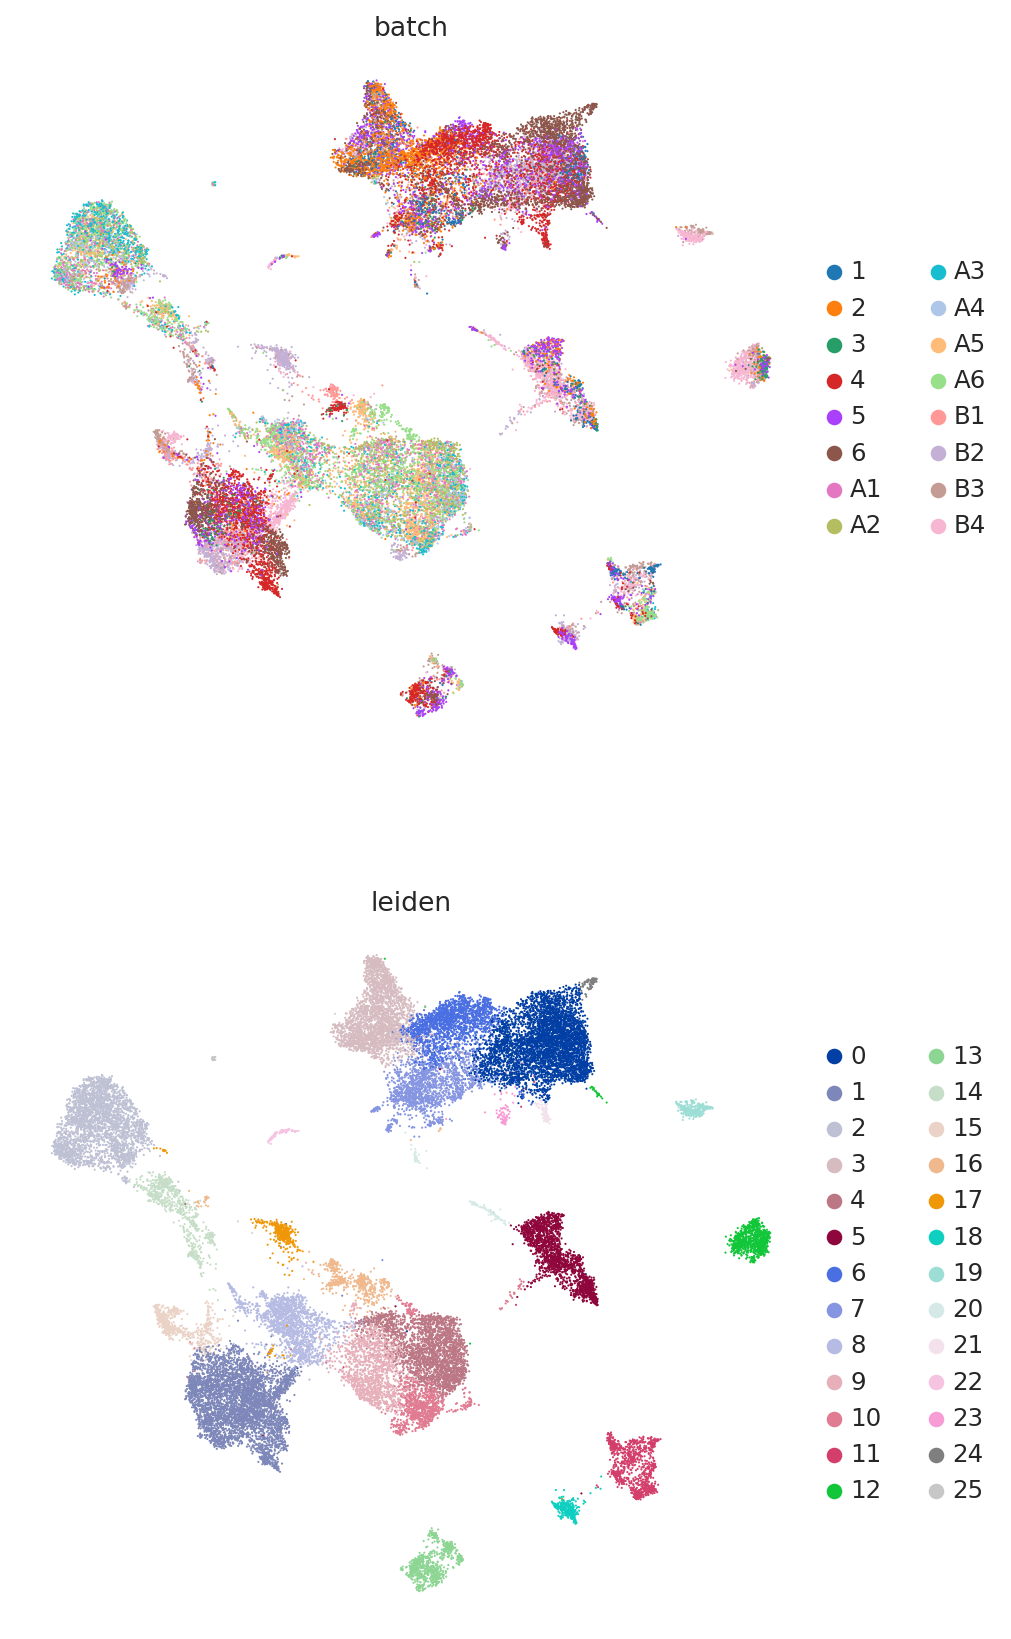

In [11]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well.

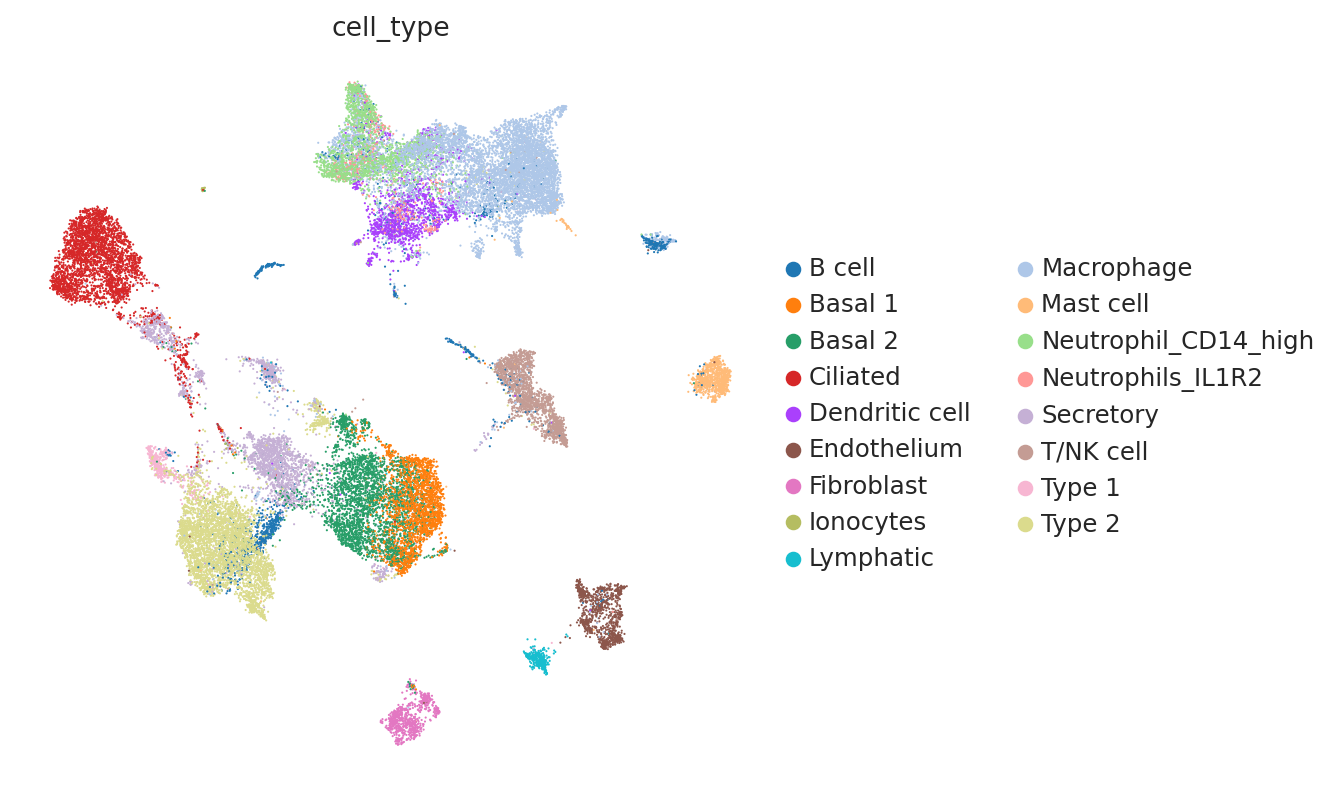

In [12]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

At a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. We see that this dataset is quite complex, where only some batches contain certain cell types.

Below we quantify the performance.

## Integration with scANVI

Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

- the sample identifier for each cell (as in scVI)
- the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.

Since we've already trained an scVI model on our data, we will use it to initialize scANVI.  When initializing scANVI, we provide it the `labels_key`. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

```{important}
scANVI should be initialized from a scVI model pre-trained on the same exact data.
```

In [13]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [14]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Now we can retrieve the latent space

In [15]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [16]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

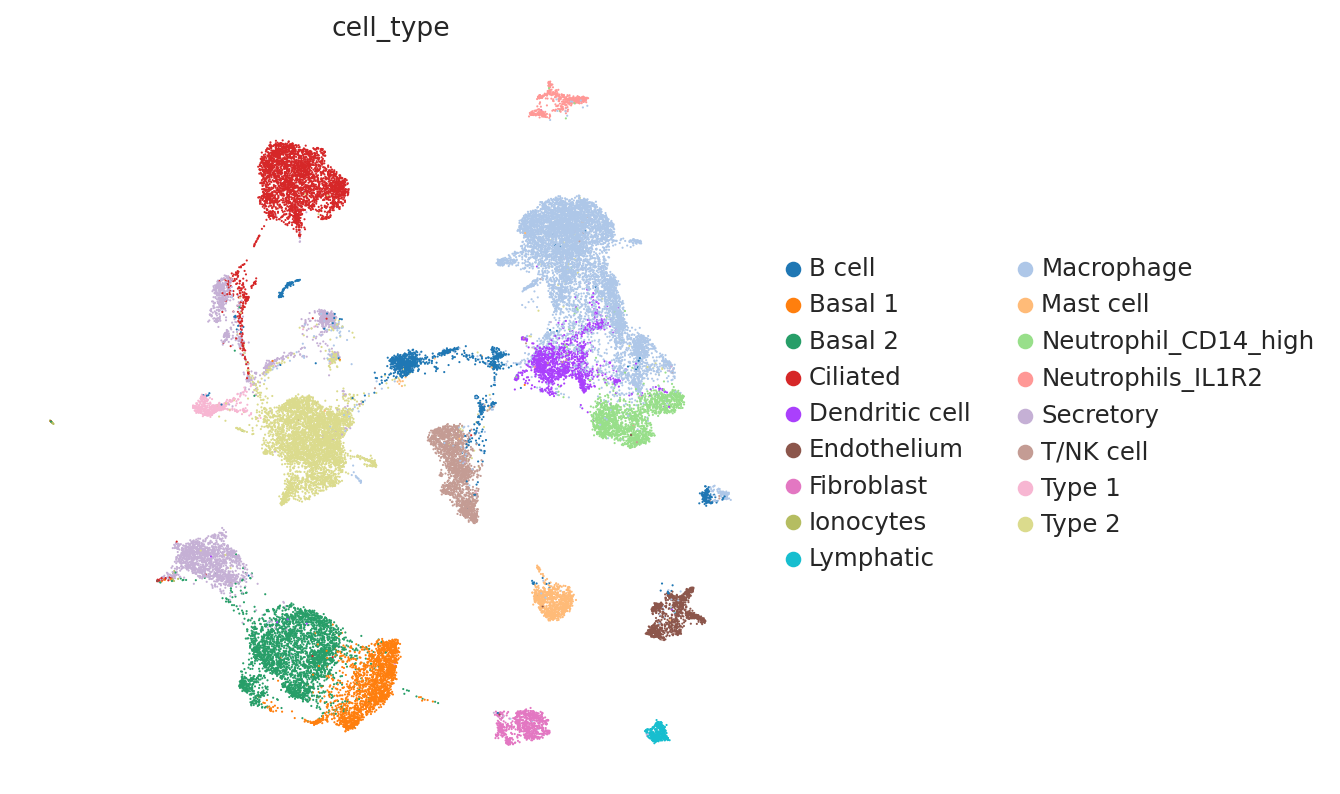

In [17]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

### Compute integration metrics

Here we use the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which contains scalable implementations of the metrics used in the scIB benchmarking suite. We can use these metrics to assess the quality of the integration.

We can see that the additional training with label information and scANVI improved the metrics that capture bio conservation (`cLISI, Silhouette labels`) without sacrificing too much batch correction power (`iLISI, Silhouette batch`)

In [18]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

/usr/local/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

Computing neighbors:  33%|███▎      | 1/3 [00:06<00:12,  6.38s/it]

Computing neighbors:  67%|██████▋   | 2/3 [00:11<00:05,  5.75s/it]

Computing neighbors: 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]

Computing neighbors: 100%|██████████| 3/3 [00:17<00:00,  5.80s/it]

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:03<00:27,  3.09s/it, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:03<00:27,  3.09s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:04<00:15,  1.94s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:04<00:15,  1.94s/it, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:05<00:09,  1.43s/it, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:05<00:09,  1.43s/it, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:06<00:08,  1.37s/it, Bio conservation: clisi_knn]

Metrics:  40%|████      | 4/10 [00:06<00:08,  1.37s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:33<00:53, 10.80s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:33<00:53, 10.80s/it, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:34<00:29,  7.38s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████    | 6/10 [00:34<00:29,  7.38s/it, Batch correction: kbet_per_label]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])



Metrics:  70%|███████   | 7/10 [00:34<00:15,  5.05s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:34<00:15,  5.05s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:34<00:10,  5.05s/it, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [00:35<00:02,  2.72s/it, Batch correction: pcr_comparison]

Embeddings:  33%|███▎      | 1/3 [00:35<01:10, 35.30s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:07,  1.18it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:07,  1.18it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:07,  1.09it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:07,  1.09it/s, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:02<00:05,  1.17it/s, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:02<00:05,  1.17it/s, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:02<00:05,  1.17it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:04<00:03,  1.11it/s, Batch correction: kbet_per_label]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])



Metrics:  70%|███████   | 7/10 [00:04<00:01,  1.78it/s, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:04<00:01,  1.78it/s, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [00:05<00:00,  2.43it/s, Batch correction: pcr_comparison]

Embeddings:  67%|██████▋   | 2/3 [00:40<00:17, 17.53s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:07,  1.27it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:07,  1.27it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:06,  1.18it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:06,  1.18it/s, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:02<00:04,  1.23it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:02<00:02,  2.49it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:02<00:02,  2.49it/s, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:02<00:01,  2.49it/s, Batch correction: kbet_per_label]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])



Metrics:  70%|███████   | 7/10 [00:02<00:00,  3.42it/s, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:02<00:00,  3.42it/s, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:02<00:00,  3.42it/s, Batch correction: pcr_comparison]    

Embeddings: 100%|██████████| 3/3 [00:43<00:00, 10.89s/it]

Embeddings: 100%|██████████| 3/3 [00:43<00:00, 14.46s/it]

/usr/local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


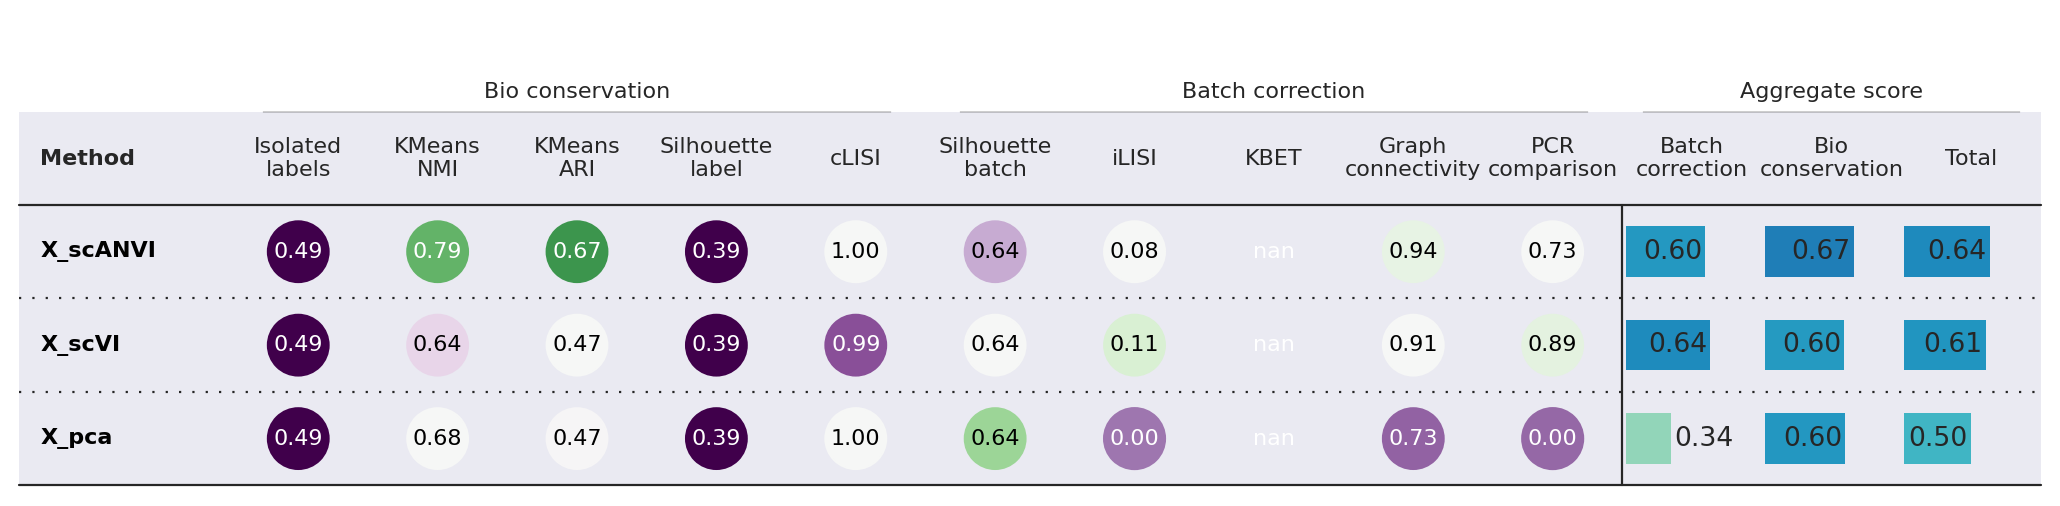

In [19]:
bm.plot_results_table(min_max_scale=False)

In [20]:
df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_pca                0.485849          0.676374          0.468682   
X_scVI               0.485849          0.639282           0.47145   
X_scANVI             0.485849          0.787692          0.674549   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_pca                0.393077               1.0          0.640224   
X_scVI               0.393077          0.993761          0.640221   
X_scANVI             0.393077               1.0          0.640218   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_pca                0.003442               NaN           0.728504   
X_scVI               0.112937               NaN           0.909104   
X_scANVI             0.084524               NaN           0.938025   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_pca                     0.0         0.343042         0.604797   
X_scVI               0.886549         0.637202         0.596684   
X_scANVI             0.734729         0.599374         0.668233   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_pca               0.500095  
X_scVI              0.612891  
X_scANVI             0.64069  
Metric Type  Aggregate score